## Laboratorio 03 
### Histogram of Gradients (HOG) de Dalal & Triggs
- Sara Echeverría 21371
- Melissa Pérez 21385
- Ricardo Mendez 21289

Repositorio: https://github.com/MelissaPerez09/Lab03-CC3102

In [1]:
# libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Task 01
Convertir una imagen a escala de grises y redimensionarla según un factor de escala

In [2]:
def preprocess_image(image_path, k=1):
    image = cv2.imread(image_path)
    
    # gray scale transformation
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # output image size
    new_size = (64 * k, 128 * k)
    
    # resize the image
    resized_image = cv2.resize(gray_image, new_size, interpolation=cv2.INTER_AREA)
    
    return resized_image

In [3]:
# show result
def convert_grays(image_path, k):
    processed_image = preprocess_image(image_path, k)
    plt.imshow(processed_image, cmap='gray')
    plt.axis('off')
    plt.title("Grayscale Image")
    plt.show()

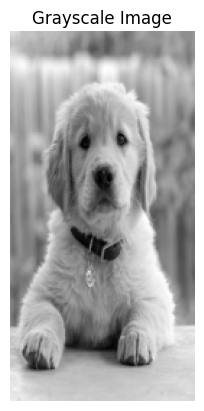

In [4]:
convert_grays("./img/golden.jpeg", 2)

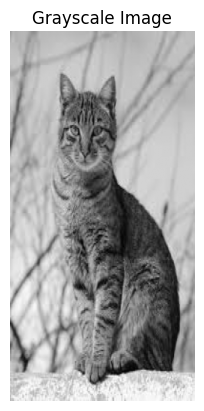

In [5]:
convert_grays("./img/cat.jpeg", 4)

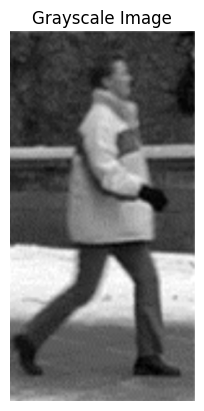

In [6]:
convert_grays("./img/person.png", 4)

### Task 02
Calcular la magnitud y el ángulo del gradiente de una imagen en escala de grises utilizando los filtros de Prewitt y Sobel.

In [7]:
# Prewitt filter
def apply_prewitt(image):
    # Prewitt kernels
    kernel_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    
    # apply filters
    prewitt_x = cv2.filter2D(image, -1, kernel_x)
    prewitt_y = cv2.filter2D(image, -1, kernel_y)
    
    # calculate the magnitude of gradients
    magnitude = cv2.addWeighted(prewitt_x, 0.5, prewitt_y, 0.5, 0)
    
    # Calcular la orientación del gradiente y llevarla al rango [0, 180)
    orientation = np.arctan2(prewitt_y, prewitt_x) * (180 / np.pi)
    orientation = np.mod(orientation, 180)
    
    return magnitude, orientation

In [8]:
# Sobel filter
def apply_sobel(image):
    # apply Sobel filters in x and y directions
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    # calculate the magnitude of gradients
    magnitude = cv2.magnitude(sobel_x, sobel_y)
    
    # calculate the orientation of the gradient and scale it to [0, 180)
    orientation = np.arctan2(sobel_y, sobel_x) * (180 / np.pi)
    orientation = np.mod(orientation, 180)
    
    return magnitude, orientation

In [9]:
# Show filter result
def show_filter_result(type, image_path, k):
    if type == "prewitt":
        processed_image = preprocess_image(image_path, k)
        magnitude, orientation = apply_prewitt(processed_image)
        filter_title = "Prewitt Filter"
    elif type == "sobel":
        processed_image = preprocess_image(image_path, k)
        magnitude, orientation = apply_sobel(processed_image)
        filter_title = "Sobel Filter"
    
    plt.figure(figsize=(4, 4))
    plt.suptitle(filter_title, fontsize=16)

    plt.subplot(1, 2, 1)
    plt.imshow(magnitude, cmap='gray')
    plt.axis('off')
    plt.title("Magnitude (µ)")

    plt.subplot(1, 2, 2)
    plt.imshow(orientation, cmap='gray')
    plt.axis('off')
    plt.title("Orientation (θ)")
    plt.show()

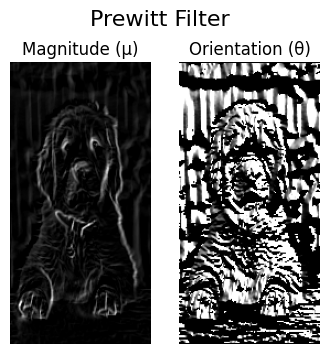

In [10]:
show_filter_result("prewitt", "./img/golden.jpeg", 2)

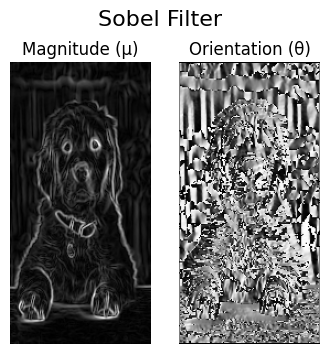

In [11]:
show_filter_result("sobel", "./img/golden.jpeg", 2)

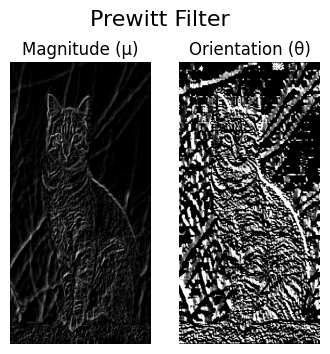

In [12]:
show_filter_result("prewitt", "./img/cat.jpeg", 4)

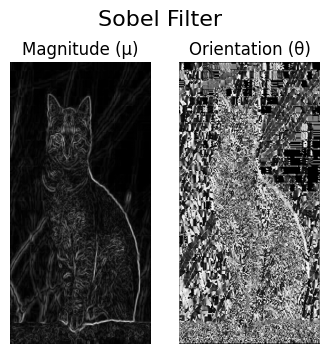

In [13]:
show_filter_result("sobel", "./img/cat.jpeg", 4)

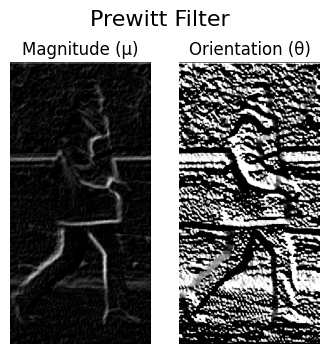

In [14]:
show_filter_result("prewitt", "./img/person.png", 4)

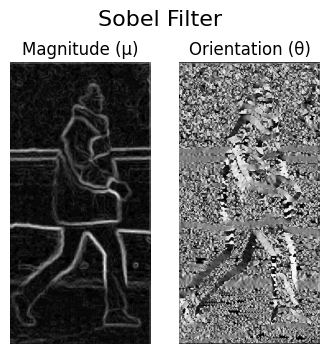

In [15]:
show_filter_result("sobel", "./img/person.png", 4)

### Task 03
Construir un conjunto de bloques de tamaño especificado para almacenar la magnitud y el ángulo del gradiente de la imagen.

### Task 04
Generar histogramas de gradientes a partir de los bloques calculados, asignando votos a los bines mediante interpolación bilineal.

### Task 05
Visualizar los histogramas de cada bloque en una imagen con fondo negro, representando las direcciones de los gradientes.

### Task 06
Comparar la implementación propia del algoritmo HOG con la versión de la función _hog_ de _scikit-image_.

### Task 07
Implementar un método de detección de personas usando OpenCV y visualizar los resultados sobre imágenes de prueba.